## Load libraries

In [1]:
pip install owslib rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.1 MB/s eta 0:00:00


In [2]:
from owslib.wms import WebMapService
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import display
from IPython.display import Image as displayImage
import io
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
import geopandas as gpd

## Set up WMS and layer

This code was partly taken from: [OWSLib 0.29.3 documentation -> Examples -> Interact with a WMS](https://owslib.readthedocs.io/en/stable/notebooks/wms.html)

In [3]:
# Define test wms url

test_wms_url = 'https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?'

In [4]:
def get_wms_information(wms_url):
    """
    Output all necessary WMS information for the WMS service provided
    wms_url: The GetCapabilities url of the WMS service
    Returns: dictionary with version, url, title, abstract, provider_name, layer_names, operations, operations_urls, format_options
    """

    wms = WebMapService(wms_url, version="1.3.0")

    version = wms.identification.version
    title = wms.identification.title
    abstract = wms.identification.abstract
    provider_name = wms.provider.name
    layer_names = list(wms.contents)
    operations = [op.name for op in wms.operations]
    operations_urls = wms.getOperationByName('GetMap').methods
    format_options = wms.getOperationByName('GetMap').formatOptions

    wms_information = {"version": version,
                       "url": wms_url,
                       "title": title,
                       "abstract": abstract,
                       "provider_name": provider_name,
                       "layer_names": layer_names,
                       "operations": operations,
                       "operations_urls": operations_urls,
                       "format_options": format_options
                       }
    return wms_information

In [5]:
# Test get_layer_information function
get_wms_information(test_wms_url)

{'version': '1.3.0',
 'url': 'https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?',
 'title': 'ADV-WMS-DE-SN-DOP-RGB',
 'abstract': 'AdV WMS zur Darstellung der digitalen Orthophotos in Farbe (RGB). DOP sind in die Ebene entzerrte, georeferenzierte Luftbilder. Dabei erfolgt die Projektion der Luftbilder über ein Digitales Geländemodell (DGM) der Erdoberfläche. Seit 2005 werden im Landesamt für Geobasisinformation Sachsen Orthophotos auf Grundlage von Luftbildern aus Bildflügen mit digitalen Kameras erzeugt. Sie besitzen eine Bodenauflösung von 0,20 m.\nWeitere Informationen zum Dienst erhalten Sie im GeoMIS.Sachsen oder über die Metadatenanzeige welche über folgende URL direkt aufrufbar ist: https://geoportal.sachsen.de/cps/metadaten_portal.html?id=26df8686-08cd-4dc2-b459-4d51b9badfe8 Abruf des Dienstestatus GeoBAK2.0-Monitoring über: https://geoportal.sachsen.de/ampel/geodienstestatus?url=https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?REQUEST=GetCapabilities&SERVICE=WMS (3-o

In [6]:
def get_layer_information(wms_url, layer_name):
    """
    Retrieve information about extent and crs_options of selected layer
    wms_url: The GetCapabilities url of the WMS service
    layer_name: The name of the selected layer
    Returns: dictionary with layer_name, extent, crs_options
    """
    wms = WebMapService(wms_url, version="1.3.0")

    extent = wms.contents[layer_name].boundingBoxWGS84
    crs_options = wms[layer_name].crsOptions

    layer_information = {"layer_name": layer_name,
                         "extent": extent,
                         "crs_options": crs_options
                         }
    return layer_information

In [7]:
# Define test_layer
test_layer = 'sn_dop_020'

In [8]:
get_layer_information(test_wms_url, test_layer)

{'layer_name': 'sn_dop_020',
 'extent': (11.788898, 50.150604, 15.08686, 51.72093),
 'crs_options': ['EPSG:102100',
  'EPSG:4258',
  'EPSG:3045',
  'EPSG:3034',
  'EPSG:31467',
  'EPSG:31463',
  'EPSG:3399',
  'EPSG:3398',
  'EPSG:25833',
  'EPSG:31462',
  'EPSG:3857',
  'EPSG:2180',
  'EPSG:102067',
  'EPSG:31464',
  'EPSG:5514',
  'EPSG:31465',
  'EPSG:31466',
  'EPSG:31468',
  'EPSG:3035',
  'CRS:84',
  'EPSG:3044',
  'EPSG:4326',
  'EPSG:31469',
  'EPSG:25832',
  'EPSG:5650']}

## Show and Download Map

In [356]:
# Set test bounding box
test_bounding_box = [8.42191544, 52.91467249, 8.42508244, 52.91489671]

In [10]:
def encapsulate_in_square_bbox(bounding_box):
    """
    Function to calculate encapsulating, square bounding box
    """

    lat_min, lon_min, lat_max, lon_max = bounding_box

    # Calculate the midpoints of the existing bounding box
    mid_lat = (lat_max + lat_min) / 2
    mid_lon = (lon_max + lon_min) / 2

    # Calculate the max spans
    span_lat = (lat_max - lat_min) / 2
    span_lon = (lon_max - lon_min) / 2

    max_span = max(span_lat, span_lon)

    lat_min_new = mid_lat - max_span
    lat_max_new = mid_lat + max_span
    lon_min_new = mid_lon - max_span
    lon_max_new = mid_lon + max_span

    square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

    return square_bbox

In [485]:
# Calculate encapsulating square bounding box of test bounding box

square_bbox = encapsulate_in_square_bbox(test_bbox_sachsen)
print(square_bbox)

[12.305342, 51.4114885, 12.309588999999999, 51.415735500000004]


In [486]:
wms = WebMapService(url = 'https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?', version = "1.3.0")

In [488]:
# Create map using square bounding box
img = wms.getmap(
    layers=['sn_dop_020'],
    size=[100, 100], # Set appropriate pixel size
    srs="EPSG:4326",
    bbox=square_bbox,
    format="image/jpeg")

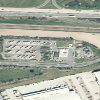

In [489]:
displayImage(img.read())

In [11]:
# Specify downloading function

def download_map(image, filepath):

    # Assuming img_new is your image response object
    image_data = BytesIO(image.read())

    # Write the image data to a file
    with open(filepath, 'wb') as file:
        file.write(image_data.getvalue())

    # Provide the file path for downloading
    print("Download link:", filepath)

In [ ]:
# Download image

file_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01c DOP Test Download/test_image_3.jpg'

download_map(img, file_path)

Download link: /content/drive/MyDrive/Master Thesis/01 Data Acquisition/01c DOP Test Download/test_image_3.jpg


In [12]:
# Specify function to check pixel width and height

def pixel_dimensions(image):

    image_data = BytesIO(image.read())
    image_loaded = Image.open(image_data)

    # Get image dimensions (Width x Height)
    width, height = image_loaded.size

    return (width, height)

In [528]:
# Show dimensions
pixel_dimensions(img)

(100, 100)

## Define layer to download from given bbox

In [9]:
# Define WMS service and layer for each Land

wms_urls = {
        'WMS_NI_DOP': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', # Lower Saxony
        'bebb_dop20c': 'https://isk.geobasis-bb.de/mapproxy/dop20c/service/wms?Request=GetCapabilities&Service=WMS', # Brandenburg & Berlin
        'th_dop': 'https://www.geoproxy.geoportal-th.de/geoproxy/services/DOP?REQUEST=GetCapabilities&version=1.1.1&service=WMS', # Thuringia
        'lsa_lvermgeo_dop20_2': 'https://www.geodatenportal.sachsen-anhalt.de/wss/service/ST_LVermGeo_DOP_WMS_OpenData/guest?', # Saxony-Anhalt
        'he_dop_rgb': 'https://gds-srv.hessen.de/cgi-bin/lika-services/ogc-free-images.ows?', # Hessia
        'sh_dop20_rgb': 'https://dienste.gdi-sh.de/WMS_SH_DOP20col_OpenGBD?Service=wms&version=1.3.0&request=getCapabilities', # Schleswig-Holstein
        #'sn_dop_020': 'https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?', # Saxony
    }

*   sh_dop20_rgb has an overly large extent. For this reason, this layer is tested last

In [13]:
# Print WMS and layer information for all selected Länder layers
counter = 1

for layer, url in wms_urls.items():
    print(f"wms_{counter}", get_wms_information(url))
    print(f"layer_{counter}", get_layer_information(url, layer))
    print("\n")
    counter += 1

wms_1 {'version': '1.3.0', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', 'title': 'WMS NI DOP', 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)', 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation', 'layer_names': ['WMS_NI_DOP', 'dop20'], 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'], 'operations_urls': [{'type': 'Get', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}, {'type': 'Post', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}], 'format_options': ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8', 'application/x-pdf', 'image/svg+xml', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz', 'application/vnd.mapbox-vector-tile', 'applic

**Findings:**

*   All layers have the option to select the EPSG:4326 coordinate system, a coordinate system on the WGS84 reference ellipsoid
*   WGS84 is also used as the standard coordinates system used by GSP and also OSM
*   Only Niedersachsen, Thüringen and Hessen can export in Tiff format

In [14]:
def retrieve_layer_extents(wms_urls):
        """
        Retrieve layer extents of the urls provided.
        wms_urls: dictionary of map names and WMS GetCapability URLs
        Returns: dictionary of the extents of the WMS layers
        """
        wms_layer_extents = {}

        for layer_name, url in wms_urls.items():
            bounding_box = get_layer_information(url, layer_name)["extent"]
            wms_layer_extents[layer_name] = bounding_box

        return wms_layer_extents

In [15]:
layer_extents = retrieve_layer_extents(wms_urls)
print(layer_extents)

{'WMS_NI_DOP': (6.505772, 51.153098, 11.754046, 54.148101), 'bebb_dop20c': (11.152768795679583, 51.2635170116316, 15.009068839315324, 53.61004915755329), 'th_dop': (9.70043908, 50.13516795, 12.75958006, 51.7188448), 'lsa_lvermgeo_dop20_2': (10.5092, 50.8927, 13.3233, 53.0769), 'he_dop_rgb': (7.41867, 49.25, 10.5, 51.7596), 'sh_dop20_rgb': (0.105946742406, 45.237542736, 20.4488912945, 56.8478734515)}


In [16]:
def create_png_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square map from provided bounding box based on the needed WMS
    bbox: (left, bottom, right, top)
    wms_urls: dictionary containing layer_names as keys and urls as values
    Returns: image of the map
    """

    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.
        bbox1 and bbox2: (left, bottom, right, top)
        Returns: True if they intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, the comparison needs to be adjusted
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # For other modes, you might need a different approach
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False

    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based on the provided bounding box.
        user_bbox: The bounding box (left, bottom, right, top)
        layer_extents: Dictionary of layer names and their extent bounding boc
        Returns: Layer name or None if no intersection
        """
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(2, 2),
                              format='image/png')
            if not bbox_intersects(bbox, extent):
                print(f"{layer} does not contain bounding box.")
            elif is_blank_image(response):
                print(f"{layer} returns blank image")
            else:
                print(f"{layer} returns image")
                return layer
        return None


    def encapsulate_in_square_bbox(bounding_box):
        """
        Function to calculate encapsulating, square bounding box
        """

        lat_min, lon_min, lat_max, lon_max = bounding_box

        # Calculate the midpoints of the existing bounding box
        mid_lat = (lat_max + lat_min) / 2
        mid_lon = (lon_max + lon_min) / 2

        # Calculate the max spans
        span_lat = (lat_max - lat_min) / 2
        span_lon = (lon_max - lon_min) / 2

        max_span = max(span_lat, span_lon)

        lat_min_new = mid_lat - max_span
        lat_max_new = mid_lat + max_span
        lon_min_new = mid_lon - max_span
        lon_max_new = mid_lon + max_span

        square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

        return square_bbox

    # Create square bounding box from input bounding box
    square_bbox = encapsulate_in_square_bbox(bbox)

    # Determine the layer that intersects the bounding box
    chosen_layer = determine_layer_for_bbox(square_bbox, wms_urls, layer_extents)

    if chosen_layer == None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        # Correctly create a WebMapService object
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(size, size),
                              format='image/png')
    return response

In [79]:
# Define test bounding boxes

test_bbox_niedersachsen = [8.42191544, 52.91467249, 8.42508244, 52.91489671]
test_bbox_brandenburg = [13.015424, 52.300345, 13.020988, 52.302384]
test_bbox_thüringen = [11.196242, 50.947367, 11.200492, 50.948778]
test_bbox_sh = [9.939001, 53.717082, 9.939979, 53.720104]
test_bbox_sachsen = [12.305342, 51.413025, 12.309589, 51.414199]
test_bbox_hessen = [8.350782, 50.094450, 8.354213, 50.099812]
test_bbox_fail = [8.4231, 48.375354, 8.4421, 48.385273]
test_bbox_magdeburg = [11.448439, 52.183663, 11.455710, 52.186811]

In [43]:
# Example usage
try:
    response = create_png_from_bbox(test_bbox_niedersachsen, wms_urls, layer_extents, size = 500)
    # Further code to handle the response
except ValueError as e:
    print(e)

WMS_NI_DOP returns image


In [41]:
displayImage(response.read())

Output hidden; open in https://colab.research.google.com to view.

In [42]:
pixel_dimensions(response)

(1000, 1000)

In [21]:
response

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Assuming you have saved your WMS response as a raster file
raster_file = 'path_to_your_raster_file.tif'  # replace with your file path

# Open the raster file
with rasterio.open(raster_file) as src:
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax)

    # Create a polygon using Shapely and add it to a GeoDataFrame
    polygon_geom = Polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4)])  # replace with your coordinates
    polygon = gpd.GeoDataFrame(index=[0], crs=src.crs, geometry=[polygon_geom])

    # Plot the polygon on top of the raster
    polygon.plot(ax=ax, facecolor="none", edgecolor="red")

plt.show()


## Try GeoTiff download

In [22]:
def create_tif_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square map from provided bounding box based on the needed WMS
    bbox: (left, bottom, right, top)
    wms_urls: dictionary containing layer_names as keys and urls as values
    Returns: image of the map
    """

    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.
        bbox1 and bbox2: (left, bottom, right, top)
        Returns: True if they intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, the comparison needs to be adjusted
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # For other modes, you might need a different approach
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False

    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based on the provided bounding box.
        user_bbox: The bounding box (left, bottom, right, top)
        layer_extents: Dictionary of layer names and their extent bounding boc
        Returns: Layer name or None if no intersection
        """
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(2, 2),
                              format='image/png')
            if not bbox_intersects(bbox, extent):
                print(f"{layer} does not contain bounding box.")
            elif is_blank_image(response):
                print(f"{layer} returns blank image")
            else:
                print(f"{layer} returns image")
                return layer
        return None


    def encapsulate_in_square_bbox(bounding_box):
        """
        Function to calculate encapsulating, square bounding box
        """

        lat_min, lon_min, lat_max, lon_max = bounding_box

        # Calculate the midpoints of the existing bounding box
        mid_lat = (lat_max + lat_min) / 2
        mid_lon = (lon_max + lon_min) / 2

        # Calculate the max spans
        span_lat = (lat_max - lat_min) / 2
        span_lon = (lon_max - lon_min) / 2

        max_span = max(span_lat, span_lon)

        lat_min_new = mid_lat - max_span
        lat_max_new = mid_lat + max_span
        lon_min_new = mid_lon - max_span
        lon_max_new = mid_lon + max_span

        square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

        return square_bbox

    square_bbox = encapsulate_in_square_bbox(bbox)
    chosen_layer = determine_layer_for_bbox(square_bbox, wms_urls, layer_extents)

    if chosen_layer is None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(size, size),
                              format='image/tiff')
        return response, square_bbox

In [24]:
def save_as_geotiff(image_response, bbox, output_filename):
    """
    Save the image response as a GeoTIFF file.
    """
    image = Image.open(io.BytesIO(image_response.read()))
    image_array = np.array(image)

    if len(image_array.shape) == 2:
        image_array = np.expand_dims(image_array, axis=2)

    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=image_array.shape[0],
        width=image_array.shape[1],
        count=image_array.shape[2],  # Number of bands
        dtype=image_array.dtype,
        crs='EPSG:4326',
        transform=from_bounds(*bbox, image_array.shape[1], image_array.shape[0])
    ) as dst:
        for i in range(image_array.shape[2]):
            dst.write(image_array[:, :, i], i + 1)

In [48]:
# Example usage
test_bbox_niedersachsen = [8.42191544, 52.91467249, 8.42508244, 52.91489671]
try:
    response, square_bbox = create_tif_from_bbox(test_bbox_niedersachsen, wms_urls, layer_extents, size=100)
    save_as_geotiff(response, square_bbox, '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_satellite_image_ns_2.tif')
except Exception as e:
    print(f"An error occurred: {e}")

WMS_NI_DOP returns image


### Load GeoTiff

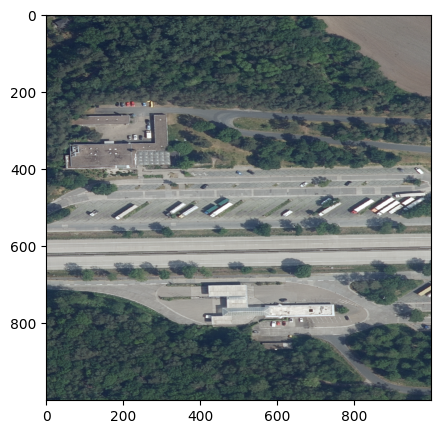

In [60]:
# Step 1: Load the satellite image
satellite_image_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_satellite_image_ns_1.tif'  # Replace with your image path
with rasterio.open(satellite_image_path) as src:
    # Read all bands
    data = src.read()

    # Check if we have 3 bands (RGB)
    if data.shape[0] == 3:
        # Reshape from (3, height, width) to (height, width, 3)
        satellite_image = np.moveaxis(data, 0, -1)
    else:
        raise ValueError("The image does not have 3 bands. Check your image data.")

# Plot the figure
fig, ax = plt.subplots(figsize=(5, 5))
# Show the RGB satellite image using imshow
ax.imshow(satellite_image)

plt.show()

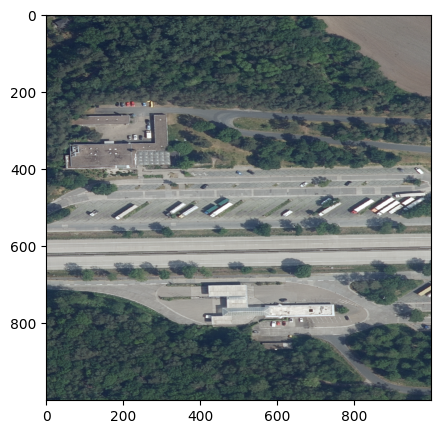

In [65]:
fig

In [66]:
from shapely.geometry import box

# Step 2: Create a rectangular polygon within the bounding box
bbox = [8.42191544, 52.91467249, 8.42508244, 52.91489671]  # minx, miny, maxx, maxy
rectangle_polygon = box(*bbox)  # Create a rectangular polygon from the bounding box
polygons = gpd.GeoDataFrame({'geometry': [rectangle_polygon]}, crs=src.crs)  # Create a GeoDataFrame

polygons.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2)  # Overlay the polygon

<Axes: >

<Figure size 640x480 with 0 Axes>

In [67]:
plt.show()

In [70]:
# Original bounding box
bbox = [8.42191544, 52.91467249, 8.42508244, 52.91489671]

# Calculate a smaller box by shrinking the original bounding box by a small delta
delta = 0.0001  # This value controls how much smaller the new box will be
smaller_bbox = [
    bbox[0] + delta,  # left
    bbox[1] + delta,  # bottom
    bbox[2] - delta,  # right
    bbox[3] - delta   # top
]

# Create the vertices of the polygon (clockwise or counter-clockwise)
poly_coords = [
    (smaller_bbox[0], smaller_bbox[1]),  # Bottom left
    (smaller_bbox[0], smaller_bbox[3]),  # Top left
    (smaller_bbox[2], smaller_bbox[3]),  # Top right
    (smaller_bbox[2], smaller_bbox[1])   # Bottom right
]

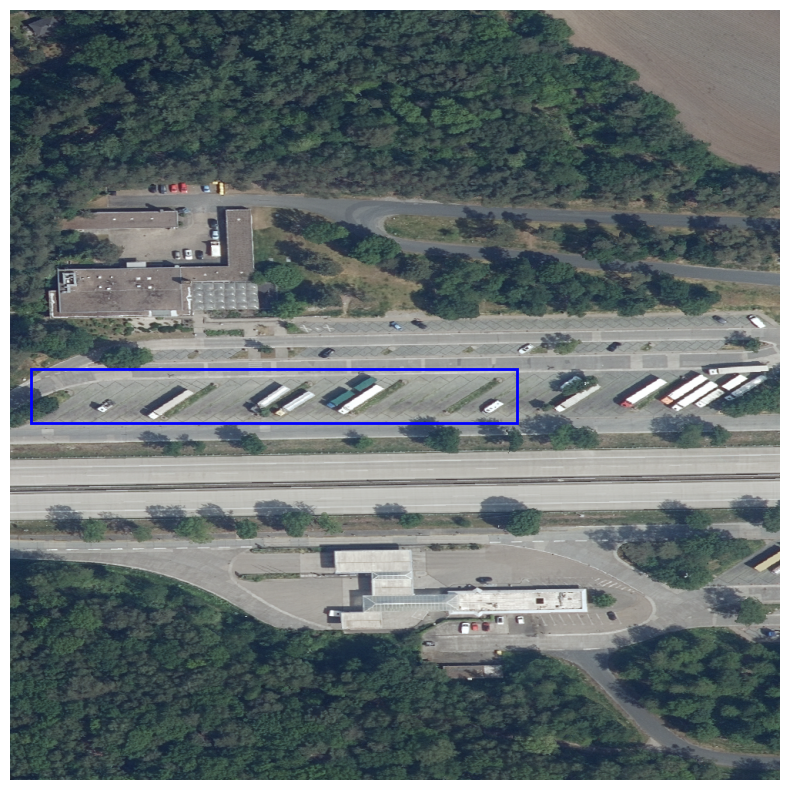

In [76]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Open the GeoTIFF file
geotiff_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_satellite_image_ns_1.tif'  # Replace with the path to your GeoTIFF file
with rasterio.open(geotiff_path) as src:
    # Read the image data
    image_data = src.read()
    transform = src.transform
    crs = src.crs

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
show(image_data, ax=ax, transform=transform)

# Define the coordinates for the polygon you want to draw
# Assuming the coordinates are in the same CRS as the GeoTIFF
poly_coords = [
    (8.422, 52.91467),
    (8.422, 52.91489),
    (8.424, 52.91489),
    (8.424, 52.91467)
]

# Create the polygon patch with a blue frame
polygon = Polygon(poly_coords, edgecolor='blue', facecolor='none', linewidth=2, transform=ax.transData)

# Add the polygon to the axes
ax.add_patch(polygon)

# Set the axes limits based on the image bounds
ax.set_xlim([transform[2], transform[2] + transform[0] * image_data.shape[2]])
ax.set_ylim([transform[5] + transform[4] * image_data.shape[1], transform[5]])

# Hide the axis labels
ax.set_axis_off()

# Display the figure
plt.show()

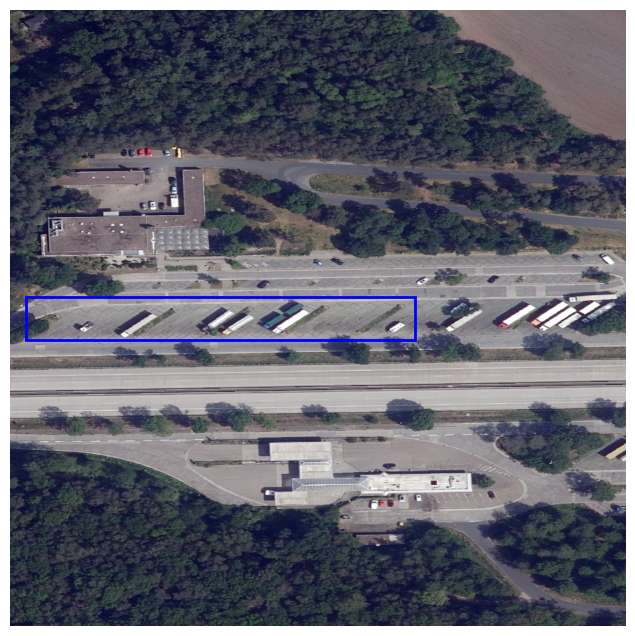

In [77]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Open the GeoTIFF file
geotiff_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_satellite_image_ns_1.tif'
with rasterio.open(geotiff_path) as src:
    # Read the image data
    image_data = src.read()
    transform = src.transform
    crs = src.crs

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size

# Display the image
show(image_data, ax=ax, transform=transform, adjust='datalim')

# Define the coordinates for the polygon you want to draw
poly_coords = [
    (8.422, 52.91467),
    (8.422, 52.91489),
    (8.424, 52.91489),
    (8.424, 52.91467)
]

# Create the polygon patch with a blue frame
polygon = Polygon(poly_coords, edgecolor='blue', facecolor='none', linewidth=2)

# Add the polygon to the axes
ax.add_patch(polygon)

# Set the aspect of the axes to be equal, this will ensure the image isn't stretched
ax.set_aspect('equal')

# Hide the axis labels
ax.set_axis_off()

# Display the figure
plt.show()


In [78]:
# Save the figure
output_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_figure.png'  # Replace with your path
fig.savefig(output_path, bbox_inches='tight', pad_inches=0)

# Create map from GeoJSON and plot polygon

In [83]:
import geopandas as gpd

# Replace with the path to your GeoJSON file
geojson_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Wildeshausen_Nord.geojson'

# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_path)

# List to store polygons
polygons = []

# Iterate through each row in the GeoDataFrame and store the polygon
for index, row in gdf.iterrows():
    polygons.append(row['geometry'])

# Now 'polygons' list contains all the polygon geometries from the GeoJSON file
# You can access individual polygons using polygons[index]
# For example, to access the first polygon:
first_polygon = polygons[0] if len(polygons) > 0 else None

# Print first polygon to verify
print("First polygon:", first_polygon)

First polygon: POLYGON ((8.4279727 52.9146601, 8.4279556 52.914723, 8.4279308 52.914814, 8.4275983 52.91484, 8.4273139 52.9148915, 8.4270396 52.9150174, 8.4265356 52.9152801, 8.4257311 52.9152683, 8.4257419 52.9151661, 8.4255687 52.9151784, 8.4251189 52.9150626, 8.4249449 52.9151461, 8.4247735 52.9151443, 8.4236685 52.9151328, 8.4231043 52.9151269, 8.423074 52.9152411, 8.422973 52.9152793, 8.4229483 52.9155555, 8.4230352 52.9156439, 8.4220746 52.915614, 8.4220937 52.9149428, 8.4215433 52.9146955, 8.4212107 52.9146571, 8.4212294 52.9145883, 8.4212453 52.9145301, 8.4279727 52.9146601))


In [89]:
from shapely.geometry import Polygon

def transform_to_square_bbox_with_buffer(polygon, buffer_distance):
    """
    Transforms a polygon into a square bounding box with a buffer and returns the bounds of the buffered box.

    Args:
    polygon (Polygon): The input polygon.
    buffer_distance (float): The buffer distance to apply around the square bounding box.

    Returns:
    List: The resulting buffered square bounding box bounds as [left, bottom, right, top].
    """
    # Calculate the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Determine the side length of the new square (the longer side of the original bounding box)
    side_length = max(maxx - minx, maxy - miny)

    # Calculate the center of the original bounding box
    center_x = minx + (maxx - minx) / 2
    center_y = miny + (maxy - miny) / 2

    # Create the square bounding box
    square_bbox = Polygon([
        (center_x - side_length / 2, center_y - side_length / 2),
        (center_x + side_length / 2, center_y - side_length / 2),
        (center_x + side_length / 2, center_y + side_length / 2),
        (center_x - side_length / 2, center_y + side_length / 2)
    ])

    # Add a buffer around the square bounding box
    buffered_square_bbox = square_bbox.buffer(buffer_distance)

    # Get the bounds of the buffered square bounding box
    buffered_bounds = buffered_square_bbox.bounds

    # Return the bounds in the format [left, bottom, right, top]
    return [buffered_bounds[0], buffered_bounds[1], buffered_bounds[2], buffered_bounds[3]]

In [99]:
buffer_distance = 0.0001  # Replace with your desired buffer distance
result_bounds = transform_to_square_bbox_with_buffer(first_polygon, buffer_distance)

print("Buffered bounding box:", result_bounds)

Buffered bounding box: [8.4211107, 52.911606, 8.428072700000001, 52.918568]


In [ ]:
# Example usage
try:
    response = create_png_from_bbox(result_bounds, wms_urls, layer_extents, size = 1000)
    # Further code to handle the response
except ValueError as e:
    print(e)

WMS_NI_DOP returns image


In [ ]:
displayImage(response.read())

In [ ]:
# Example usage
test_bbox_niedersachsen = [8.42191544, 52.91467249, 8.42508244, 52.91489671]
try:
    response, square_bbox = create_tif_from_bbox(test_bbox_niedersachsen, wms_urls, layer_extents, size=100)
    save_as_geotiff(response, square_bbox, '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/01d GeoTiff download/output_satellite_image_ns_2.tif')
except Exception as e:
    print(f"An error occurred: {e}")